In [1]:
import numpy as np

import skrf
import skrf.media as media
import skrf.frequency as freq
import skrf.network as net
import skrf.util

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

f = freq.Frequency(0.4, 2, 1001)
tem = media.DistributedCircuit(f, z0=50)

bjt = net.Network('BFU520_Spar_NF_400MHz-2GHz/BFU520_05V0_010mA_NF_SP.s2p').interpolate(f)

bjt

2-Port Network: 'BFU520_05V0_010mA_NF_SP',  0.4-2.0 GHz, 1001 pts, z0=[50.+0.j 50.+0.j]

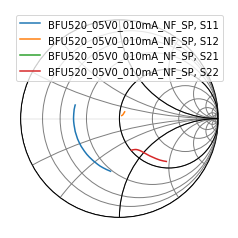

In [2]:
bjt.plot_s_smith()

In [3]:
# calculate the stability circles for the source and load impedances

idx_900mhz = skrf.util.find_nearest_index(bjt.f, 915.e+6)

sqabs = lambda x: np.square(np.absolute(x))

delta = bjt.s11.s*bjt.s22.s - bjt.s12.s*bjt.s21.s
rl = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s22.s) - sqabs(delta)))
cl = np.conj(bjt.s22.s - delta*np.conj(bjt.s11.s))/(sqabs(bjt.s22.s) - sqabs(delta))

rl_900mhz = rl[idx_900mhz][0, 0]
cl_900mhz = cl[idx_900mhz][0, 0]

rl_900mhz, cl_900mhz

(4.105588512516754, (2.478775227242761+4.2244480827589j))

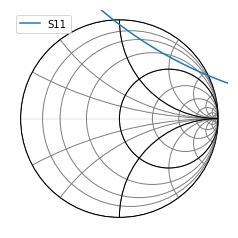

In [4]:
def calc_circle(c, r):
    theta = np.linspace(0, 2*np.pi, 1000)
    return c + r*np.exp(1.0j*theta)

def plot_smith(pts):
    n = net.Network(s=pts)
    n.plot_s_smith()
    
cl_points = calc_circle(cl_900mhz, rl_900mhz)
plot_smith(cl_points)

In [5]:
rs = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s11.s) - sqabs(delta)))
cs = np.conj(bjt.s11.s - delta*np.conj(bjt.s22.s))/(sqabs(bjt.s11.s) - sqabs(delta))

rs_900mhz = rs[idx_900mhz][0, 0]
cs_900mhz = cs[idx_900mhz][0, 0]

rs_900mhz, cs_900mhz

(2.8820382027100058, (-3.371227372367411+1.4990710463003132j))

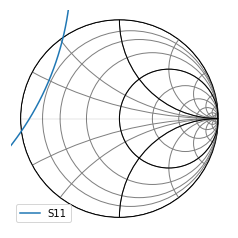

In [6]:
cs_points = calc_circle(cs_900mhz, rs_900mhz)
plot_smith(cs_points)

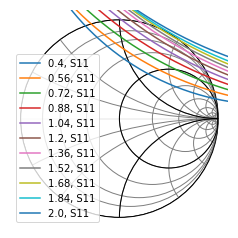

In [7]:
# let's plot all of them
# output stability first

for i, f in enumerate(bjt.f):
    # decimate it a little
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cl[i][0, 0], rl[i][0, 0]))
    n.plot_s_smith()

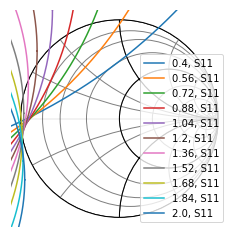

In [8]:
# input stability
for i, f in enumerate(bjt.f):
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cs[i][0, 0], rs[i][0, 0]))
    n.plot_s_smith()

In [9]:
# so not very useful, because the transistor isn't unconditionally stable
# time to draw the circles of constant gain and try to find a useful point

K = (1 - sqabs(bjt.s11.s) - sqabs(bjt.s22.s) - sqabs(delta))/(2*np.absolute((bjt.s12.s)*(bjt.s21.s)))
G_msg = np.absolute(bjt.s21.s)/np.absolute(bjt.s12.s)
10*np.log10(G_msg[idx_900mhz, 0, 0])

21.769786511748308

In [12]:
z_s = bjt.z_opt[idx_900mhz]
gamma_s = (z_s - 50)/(50. + z_s)
z_s, gamma_s

((42.1310534572952+2.4000402147640494j),
 (-0.08467428228793618+0.028256074360617726j))

In [17]:
# hmmm, is it worth matching?
# let's compare no match versus matching, no match first

# so I need to calculate the load reflection coefficient to get a conjugate match when the input sees 50 ohms
gamma_l = np.conj(bjt.s22.s - bjt.s21.s*0.0*bjt.s12.s/(1-bjt.s11.s*0.0))
is_gamma_l_stable = np.absolute(gamma_l[idx_900mhz, 0, 0] - cl_900mhz) > rl_900mhz

gamma_l = gamma_l[idx_900mhz, 0, 0]
gamma_l, is_gamma_l_stable

((0.24256371575316454+0.3420174247837097j), True)

In [18]:
z_l = net.s2z(np.array([[[gamma_l]]]))[0, 0, 0]
z_l

(59.66440251378041+49.51853683046484j)

In [33]:
Q = np.sqrt(np.real(z_l)-50./50.)
x_1 = 50./Q
x_2 = Q*np.real(z_l)

print(x_1, x_2)

l_l_shunt = x_1/(2*np.pi*915e+6)
c_l_series = 1/(2*np.pi*915e+6*x_2)

l_l_shunt, c_l_series

6.528038069522025 456.9857120804824


(1.1354858223568352e-09, 3.806242162886245e-13)

In [35]:
c_l_series2 = 1/(2*np.pi*915e+6*np.imag(z_l))
c_l_series2

3.512620518478672e-12

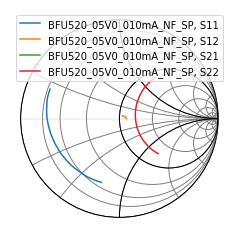

In [37]:
# TODO fix l matching network; it was apparently unstable so I switched to just adding a series resistor
output_network = tem.inductor(l_l_series2) ** tem.resistor(np.real(z_l)-50.)

amplifier_nomatch = bjt ** output_network
amplifier_nomatch.plot_s_smith()

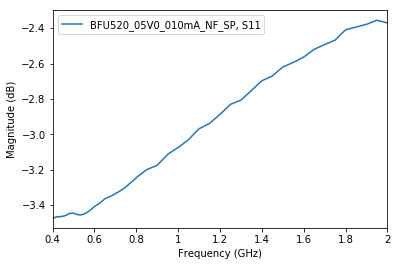

In [27]:
amplifier_nomatch.s11.plot_s_db()

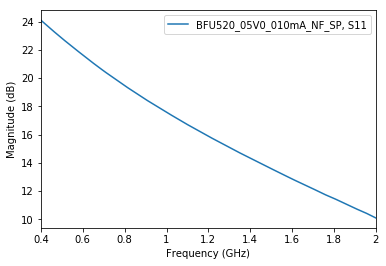

In [28]:
amplifier_nomatch.s21.plot_s_db()

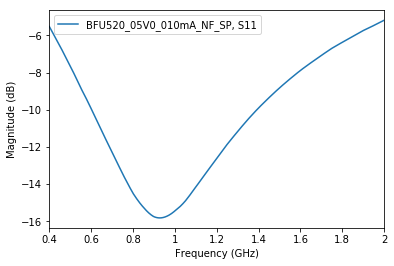

In [29]:
amplifier_nomatch.s22.plot_s_db()

In [74]:
10*np.log10(amplifier_nomatch.nf(50.)[idx_900mhz])
# so a ~0.01 dB increase?

0.9595673772253283

In [51]:
# proper input/output matching this time

Q = np.sqrt((50. - np.real(z_s))/np.real(z_s))
z_1 = 50./Q
z_2 = np.real(z_s)*Q

c_s_shunt = 1/(2*np.pi*915e+6*z_1)
l_s_series = z_2/(2*np.pi*915e+6)

c_s_shunt, l_s_series

(1.5034402448332017e-12, 3.1670760662458307e-09)

In [58]:
l_s_series2 = np.imag(z_s)/(2*np.pi*915e+6)
input_network = tem.shunt_capacitor(c_s_shunt) ** tem.inductor(l_s_series + l_s_series2)

input_network.s22.z[skrf.util.find_nearest_index(input_network.f, 915e+6), 0, 0]

(42.128154743174264+2.4018178320988497j)

In [63]:
gamma_l = np.conj(bjt.s22.s - bjt.s21.s*gamma_s*bjt.s12.s/(1-bjt.s11.s*gamma_s))
z_l = net.s2z(gamma_l)[idx_900mhz, 0, 0]
gamma_l[idx_900mhz, 0, 0], z_l

((0.21999099915891857+0.3069703855115699j),
 (61.01041883090126+43.687843380752746j))

In [64]:
Q = np.sqrt((np.real(z_l) - 50.)/np.real(z_l))
z_1 = np.real(z_l)/Q
z_2 = 50.*Q

c_l_shunt = 1/(2*np.pi*915e+6*z_1)
l_l_series = z_2/(2*np.pi*915e+6)

c_l_shunt, l_l_series

(1.2111416735467888e-12, 3.6946130383324136e-09)

In [68]:
l_l_series2 = np.imag(z_l)/(2*np.pi*915e+6)
output_network = tem.inductor(l_l_series2) ** tem.shunt_capacitor(c_l_shunt) ** tem.inductor(l_l_series)
output_network.s11.s[skrf.util.find_nearest_index(output_network.f, 915e+6), 0, 0], l_l_series2

((0.21378095966663352+0.3210219604296472j), 7.599055985870316e-09)

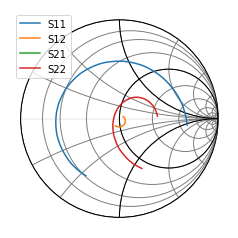

In [69]:
amplifier_matched = input_network ** bjt ** output_network
amplifier_matched.plot_s_smith()

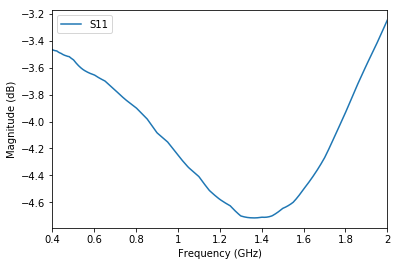

In [70]:
amplifier_matched.s11.plot_s_db()

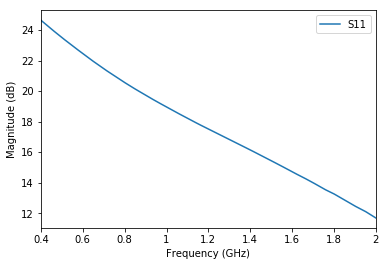

In [71]:
amplifier_matched.s21.plot_s_db()

In [73]:
10*np.log10(amplifier_matched.nf(50.)[idx_900mhz])

0.9472193660076027

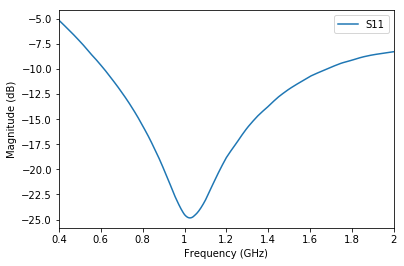

In [75]:
amplifier_matched.s22.plot_s_db()

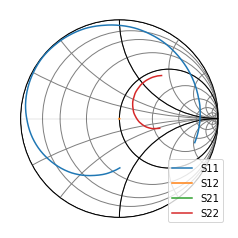

In [88]:
amplifier2 = amplifier_matched ** amplifier_nomatch
amplifier2.plot_s_smith()

In [93]:
10*np.log10(amplifier2.nf(50.))[idx_900mhz]

0.9565848959581629

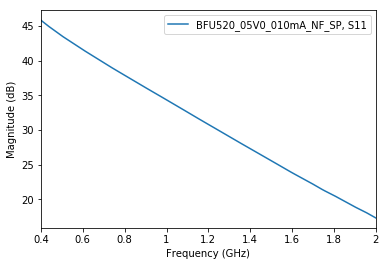

In [84]:
amplifier2.s21.plot_s_db()

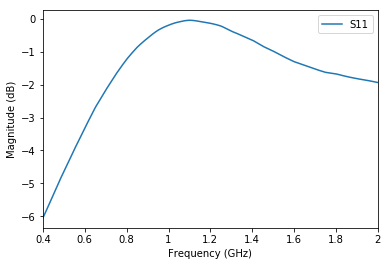

In [90]:
amplifier2.s11.plot_s_db()

In [ ]:
# that's really close to unstable so I'm going to use the unmatched version